In [1]:
!pip install pandas_bokeh

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pandas_bokeh

from datetime import timedelta, date

In [3]:
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [4]:
print("Inizio download dataset da github\n...")    
url="https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/anagrafica-vaccini-summary-latest.csv"
df_anagrafica = pd.read_csv(url) #, parse_dates = ['ultimo_aggiornamento']
url="https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/platea.csv"
df_platea = pd.read_csv(url)
url="https://github.com/italia/covid19-opendata-vaccini/raw/master/dati/platea-dose-addizionale-booster.csv"
df_platea_booster = pd.read_csv(url)
url="https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-latest.csv"
df_somministrazione = pd.read_csv(url, parse_dates = ['data_somministrazione'])
url="https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-summary-latest.csv"
df_somministrazione_summary = pd.read_csv(url, parse_dates = ['data_somministrazione'])
print("Fine download")
    

Inizio download dataset da github
...
Fine download


# Analisi

## Andamento vaccini totale - prima, seconda, booster

In [5]:
#Raggruppo somministrazioDF per togliere la distinzione tra regioni 
df_somm_grouped = df_somministrazione_summary.groupby('data_somministrazione').sum()

In [6]:
g = df_somm_grouped.plot_bokeh(y = [\
                           'prima_dose','seconda_dose', 'dose_addizionale_booster', 'pregressa_infezione'],
                           vertical_xlabel = True, title="-----------", figsize=(950, 500),\
                               legend="top_left", stacked=True, kind='bar')#, logy=True)

### Andamento storico somministrazione dosi con media settimanale

In [7]:
g = df_somm_grouped.resample(rule='W').mean().plot_bokeh(y = [\
                           'prima_dose','seconda_dose', 'dose_addizionale_booster', 'pregressa_infezione'],
                           vertical_xlabel = True, title="Somministrazione dosi con media settimanale", figsize=(950, 500),\
                               legend="top_left", stacked=True, kind='bar')#, logy=True)

In [8]:
g = df_somm_grouped.plot_bokeh(y = ['prima_dose','seconda_dose', 'dose_addizionale_booster',\
                                    'pregressa_infezione', 'totale',],
                           vertical_xlabel = True, title="-----------", figsize=(950, 500),\
                               legend="top_left")#, logy=True)

In [9]:
g = df_somm_grouped.resample(rule='W').mean().plot_bokeh(y = ['prima_dose','seconda_dose',\
                                        'dose_addizionale_booster', 'pregressa_infezione', 'totale'],
                           vertical_xlabel = True, title="-----------", figsize=(950, 500),
                                                 legend="top_left")#, logy=True)

## Vaccini per fasce anagrafiche

In [10]:
# Faccio pivot per ottenere andamento somministrazioni per ciascuna fascia di età
#faccio prima pivot intermedia per consentire di calcolare il totale dei vaccini
df_pivot = pd.pivot_table(df_somministrazione, index = ['data_somministrazione', 'fascia_anagrafica'], aggfunc=np.sum)
df_pivot.loc[:, 'totale_vaccini'] = df_pivot['prima_dose'] + df_pivot['seconda_dose']\
                        + df_pivot['dose_addizionale_booster'] + df_pivot['pregressa_infezione']
df_pivot.reset_index('fascia_anagrafica', inplace = True)
df_tot_vaccini_per_anagrafica = df_pivot.pivot(columns = 'fascia_anagrafica', values = 'totale_vaccini')

### Andamenti somministrazioni vaccini per fasce di età  
La somministrazione delle prime dosi (+ seconde dosi) ha avuto inizio scaglionato per le diverse fasce di età, mentre la somministrazione della dose booster sta avvenendo con inizio in contemporanea (eccetto per le fasce >80)

In [11]:
g = df_tot_vaccini_per_anagrafica.resample(rule='W').mean().plot_bokeh(vertical_xlabel = True,\
                        title="Fasce anagrafiche", figsize=(950, 500), legend="top_left")

### Somministrazioni settimanali vaccini, suddivisi per fasce

In [12]:
g = df_tot_vaccini_per_anagrafica.fillna(0).resample(rule='W').mean()\
.plot_bokeh(kind = 'bar', vertical_xlabel = True, title="Fasce angrafiche",\
            figsize=(950, 500), stacked = True, legend="top_left")

In [13]:
g = df_tot_vaccini_per_anagrafica.fillna(0)\
.plot_bokeh(kind = 'bar', vertical_xlabel = True, title="Fasce angrafiche", figsize=(950, 500), stacked = True, legend="top_left")

## Percentuale vaccinati per fasce anagrafiche

In [14]:
df_platea_grouped = df_platea.groupby('fascia_anagrafica').sum()

In [15]:
df_platea_booster_grouped = df_platea_booster.groupby('categoria_prevalente').sum()
df_platea_booster_grouped.rename(index={'80-89':'80+'},\
                                 columns ={'totale_popolazione': 'totale_popolazione_booster'},inplace=True)

In [16]:
#In anagrafica sono presenti le fasce '80-89' e '90+', mentre in platea vi è la fascia '80+'
#sommo le 2 face in anagrafica per uniformare
df_anag_trans = df_anagrafica.copy().set_index('fascia_anagrafica').transpose()
df_anag_trans.loc[:, '80+'] = df_anag_trans['80-89'] + df_anag_trans['90+']
#ripristino la data correttamente: 
df_anag_trans.loc['ultimo_aggiornamento','80+'] = df_anag_trans.loc['ultimo_aggiornamento','80+']\
                                        [:len(df_anag_trans.loc['ultimo_aggiornamento','80+'])//2]
df_anag_new = df_anag_trans.drop(columns=['80-89', '90+']).transpose()

In [17]:
df_fasce = pd.concat([df_anag_new, df_platea_grouped, df_platea_booster_grouped], axis = 1)

In [18]:
df_fasce.loc[:, 'percentuale_almeno_prima_dose'] = df_fasce['prima_dose'] / df_fasce['totale_popolazione']*100
df_fasce.loc[:, 'percentuale_seconda_dose'] = df_fasce['seconda_dose'] / df_fasce['totale_popolazione']*100
df_fasce.loc[:, 'percentuale_booster_su_tot'] = df_fasce['dose_addizionale_booster'] / df_fasce['totale_popolazione']*100
df_fasce.loc[:, 'percentuale_booster_su_platea_booster'] = df_fasce['dose_addizionale_booster'] /\
                                                            df_fasce['totale_popolazione_booster']*100


In [19]:
def add_value_labels(ax, spacing=2, n_decimals = 1):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        f = "{:."+str(n_decimals)+"f}"
        label = f.format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.




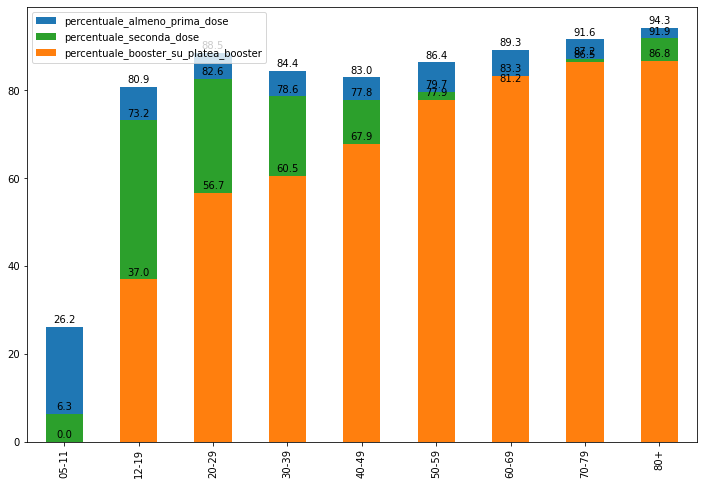

In [20]:
fig, ax = plt.subplots(figsize =(12, 8))  #figsize =(5, 5)
df_fasce.plot(kind = 'bar', y = 'percentuale_almeno_prima_dose', ax = ax, color="tab:blue")
df_fasce.plot(kind = 'bar', y = 'percentuale_seconda_dose', ax = ax, color="tab:green")
df_fasce.plot(kind = 'bar', y = 'percentuale_booster_su_platea_booster', ax = ax, color="tab:orange")
add_value_labels(ax)


### Percentuali somministrazione per face di età ad oggi

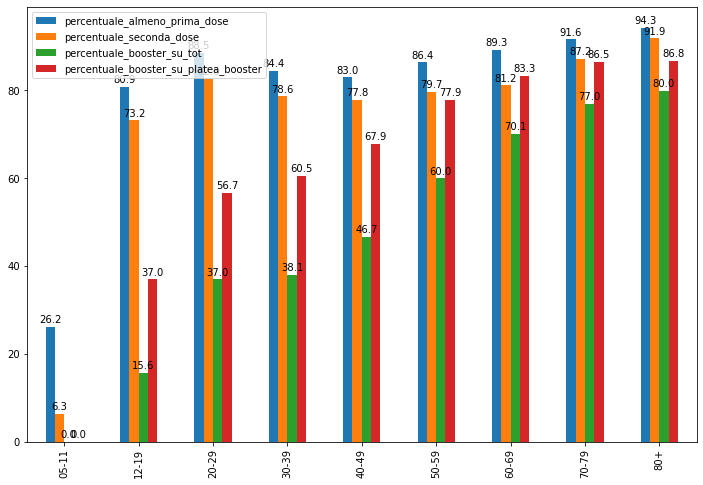

In [21]:
fig, ax = plt.subplots(figsize =(12, 8))  #figsize =(5, 5)
df_fasce.plot(kind = 'bar', y = ['percentuale_almeno_prima_dose','percentuale_seconda_dose',\
                                 'percentuale_booster_su_tot', 'percentuale_booster_su_platea_booster'], ax = ax,\
             legend='top_right')#, color="tab:blue")
#df_fasce.plot(kind = 'bar', y = 'percentuale_seconda_dose', ax = ax, color="tab:green")
#df_fasce.plot(kind = 'bar', y = 'percentuale_booster', ax = ax, color="tab:orange")
add_value_labels(ax)


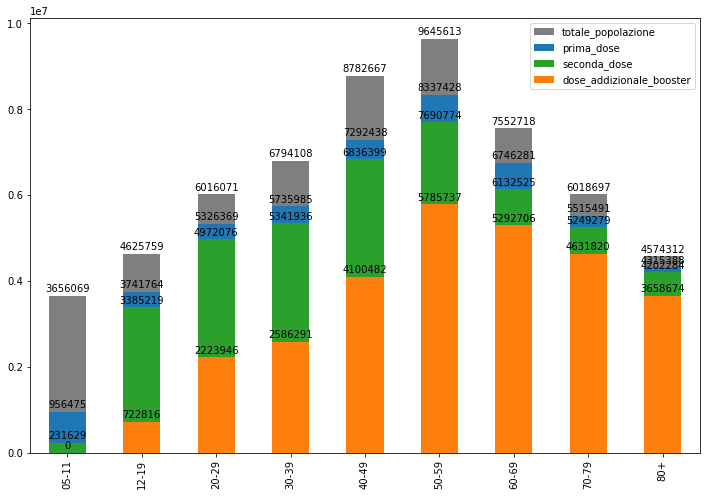

In [22]:
fig, ax = plt.subplots(figsize =(12, 8)) 
df_fasce.plot(kind = 'bar', y = 'totale_popolazione', ax = ax, color = "tab:grey")
df_fasce.plot(kind = 'bar', y = 'prima_dose', ax = ax, color="tab:blue")
df_fasce.plot(kind = 'bar', y = 'seconda_dose', ax = ax, color="tab:green" )
df_fasce.plot(kind = 'bar', y = 'dose_addizionale_booster', ax = ax, color="tab:orange")
add_value_labels(ax, spacing=2, n_decimals = 0 )


## Percentuale vaccinati sul totale

In [23]:
df_fasce_trans = df_fasce.transpose()
df_fasce_trans.loc[:, 'tot_all']  = df_fasce_trans.sum(axis=1)
df_fasce_trans.loc[:, 'tot_>12'] = df_fasce_trans.drop(columns = ['05-11', 'tot_all']).sum(axis=1)

In [24]:
# def percentuale_vaccinati(colonna, tipo_dose = 'prima_dose', totale = 'totale_popolazione'):
#     """Calcola la percentuale all'interno del dataframe df_fasce_trans.
#     Arguments:
#         colonna (str): Colonna di df_face_trans in cui si trova il valor di cui si vuole calcolare la percentuale.
#         tipo_dose (str): Tipo dose di cui calcolare perc (riga di df_fasce_trans).
#         totale (str): Totale popolazione di riferimento (riga di df_fasce_trans).
#     """
#     return round(df_fasce_trans.loc[tipo_dose, colonna]/ df_fasce_trans.loc[totale, colonna]*100, 2)

def percentuale_vaccinati(colonna, df_1 = df_fasce_trans, tipo_dose = 'prima_dose', totale = 'totale_popolazione'):
    """Calcola la percentuale all'interno del dataframe df_fasce_trans.
    Arguments:
        colonna (str): Colonna del dataframe in cui si trova il valor di cui si vuole calcolare la percentuale.
        df_1 (pandas.core.frame.DataFrame): dataframe contente i dati
        tipo_dose (str): Valore di cui si vuole calcolare la percentuale (riga del dataframe).
        totale (str): Totale di riferimento (riga dataframe).
    """
    return round(df_1.loc[tipo_dose, colonna]/ df_1.loc[totale, colonna]*100, 2)

### Percentuale totale di vaccinati almeno con prima dose sul totale della platea vaccinabile

In [25]:
percentuale_vaccinati('tot_all')

83.18

In [26]:
#prentuale sulla "platea totale esclusa la fascia 05-11 anni":
percentuale_vaccinati('tot_>12')


87.04

### Percentuale totale di vaccinati almeno con seconda dose

In [27]:
percentuale_vaccinati('tot_all', tipo_dose='seconda_dose')

76.37

In [28]:
percentuale_vaccinati('tot_>12', tipo_dose='seconda_dose')

81.12

### Percentuale totale di vaccinati booster

In [29]:
percentuale_vaccinati('tot_all', tipo_dose='dose_addizionale_booster', totale = 'totale_popolazione_booster')

73.35

In [30]:
percentuale_vaccinati('tot_all', tipo_dose='dose_addizionale_booster', totale = 'totale_popolazione')

50.29

In [31]:
percentuale_vaccinati('tot_all', tipo_dose='dose_addizionale_booster', totale = 'seconda_dose')

65.85

## Andamento somministrazione vaccini booster

In [32]:
df_platea_booster_grouped_tot = df_platea_booster_grouped.copy()
df_platea_booster_grouped_tot.loc['totale','totale_popolazione_booster'] = df_platea_booster_grouped['totale_popolazione_booster'].sum()
df_tot_booster_per_anagrafica = df_pivot.pivot(columns = 'fascia_anagrafica', values = 'dose_addizionale_booster')
df_tot_booster_per_anagrafica = df_tot_booster_per_anagrafica[df_tot_booster_per_anagrafica.index > '2021-09-12']
df_tot_booster_per_anagrafica.loc[:, 'totale'] = df_tot_booster_per_anagrafica.sum(axis=1)
df_tot_booster_per_anagrafica.loc[:, '80+'] = df_tot_booster_per_anagrafica['80-89'] + df_tot_booster_per_anagrafica['90+']
df_tot_booster_per_anagrafica.drop(columns=['80-89', '90+'], inplace = True)

In [33]:
#ricavo andamento cumulativo
df_tot_booster_per_anagrafica_cumsum = df_tot_booster_per_anagrafica.cumsum()

### Andamento cumulativo di somministrazione booster in numeri assoluti per fascia di età 

In [34]:
g = df_tot_booster_per_anagrafica_cumsum.drop(columns=['totale']).plot_bokeh(vertical_xlabel = True,\
                        title="Fasce anagrafiche", figsize=(950, 500), legend="top_left") #.resample(rule='W').mean()

In [35]:
#Ricavo percentuale per ogni fascia di età dell'andamento cumulativo
eta='12-19'
df_tot_booster_per_anagrafica_cumsum_perc =df_tot_booster_per_anagrafica_cumsum.loc[:,[eta]]/\
                df_platea_booster_grouped_tot.loc[eta, 'totale_popolazione_booster']*100

for eta in df_platea_booster_grouped_tot.index[1:]:
    df = df_tot_booster_per_anagrafica_cumsum.loc[:,[eta]]/\
                df_platea_booster_grouped_tot.loc[eta, 'totale_popolazione_booster']*100
    df_tot_booster_per_anagrafica_cumsum_perc =pd.concat([df_tot_booster_per_anagrafica_cumsum_perc, df], axis=1) 

### Andamento cumulativo percentuale (su popolazione booster) di somministrazione booster per fascia di età 

In [36]:
g = df_tot_booster_per_anagrafica_cumsum_perc.plot_bokeh(vertical_xlabel = True,\
                        title="Fasce anagrafiche", figsize=(950, 500), legend="top_left") #.resample(rule='W').mean()

In [37]:

g = df_tot_booster_per_anagrafica.plot_bokeh(y='totale',vertical_xlabel = True,\
                        title="Fasce anagrafiche", figsize=(950, 500), legend="top_left")

### Stima "a spanne" dei giorni neccessari a concludere l'inoculazione della dose booster a tutta la platea booster

In [38]:
#Media dosi booster giornarliere somministrate (media sull'ultima settimana):
media_dosi_giornaliera = int(df_tot_booster_per_anagrafica.tail(7).mean()['totale'])
media_dosi_giornaliera

493523

In [39]:
#Totale platea booster
tot_platea_booster = int(df_platea_booster_grouped_tot.loc['totale', 'totale_popolazione_booster'])
tot_platea_booster

39539599

In [40]:
#dosi booster finora somministrate
booster_somministrate = int(df_tot_booster_per_anagrafica_cumsum.loc[df_tot_booster_per_anagrafica_cumsum.index.max(), 'totale'])
booster_somministrate

29002472

In [41]:
#Percentuale platea booster finora vaccinata
booster_somministrate/tot_platea_booster*100

73.35044546101744

In [42]:
#Platea Booster a cui ancora non è stata inoculata la dose
platea_rimanente = tot_platea_booster - booster_somministrate
platea_rimanente

10537127

In [43]:
platea_rimanente/tot_platea_booster*100

26.64955453898255

#### Giorni necessari a concludere vaccinazioni platea booster

In [44]:
gg_tot = platea_rimanente//media_dosi_giornaliera
gg_tot

21

In [45]:
#Data stimata
print(df_tot_booster_per_anagrafica_cumsum_perc.index[-1] + timedelta(days=gg_tot))

2022-02-10 00:00:00


#### Giorni necessari per arrivare all'80% della platea booster vaccinata

In [46]:
gg_80 = (platea_rimanente*0.8)//media_dosi_giornaliera
gg_80

17.0

In [47]:
#Data stimata
print(df_tot_booster_per_anagrafica_cumsum_perc.index[-1] + timedelta(days=gg_80))

2022-02-06 00:00:00
